<table align="center">
  <td align="center"><a target="_blank" href="http://introtodeeplearning.com">
        <img src="https://i.ibb.co/Jr88sn2/mit.png" style="padding-bottom:5px;" />
      Visit MIT Deep Learning</a></td>
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/aamini/introtodeeplearning/blob/master/lab1/Part2_Music_Generation.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/aamini/introtodeeplearning/blob/master/lab1/Part2_Music_Generation.ipynb">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

# Copyright Information

In [ ]:
# Copyright 2021 MIT 6.S191 Introduction to Deep Learning. All Rights Reserved.
#
# Licensed under the MIT License. You may not use this file except in compliance
# with the License. Use and/or modification of this code outside of 6.S191 must
# reference:
#
# © MIT 6.S191: Introduction to Deep Learning
# http://introtodeeplearning.com
#

# Music Generation with VAE
Here, we will explore building a variational autoencoders (VAE) for music generation. We will train a model to learn the patterns in raw sheet music in [ABC notation](https://en.wikipedia.org/wiki/ABC_notation) and then use this model to generate new music.

## 1.1 Dependencies
First, let's download the course repository, install dependencies, and import the relevant packages we'll need for this lab.

In [ ]:
# Import Tensorflow 2.0
#%tensorflow_version 2.x
import tensorflow as tf

# Download and import the MIT 6.S191 package
!pip install mitdeeplearning
import mitdeeplearning as mdl

# Import all remaining packages
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
!apt-get install abcmidi timidity > /dev/null 2>&1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.6.1-py3-none-any.whl size=2118512 sha256=31749553a524e2e2b568ffe43cf68b1407e244fad3d10c4c0b795c2ec80e1262
  Stored in directory: /root/.cache/pip/wheels/a1/67/db/909c55e80ce7fc2a8dbe1bbff0e591a69d12d11136b4cfe34c
Successfully built mitdeeplearning


## 1.2 Dataset

![Let's Dance!](http://33.media.tumblr.com/3d223954ad0a77f4e98a7b87136aa395/tumblr_nlct5lFVbF1qhu7oio1_500.gif)

We've gathered a dataset of thousands of Irish folk songs, represented in the ABC notation. Let's download the dataset and inspect it:


In [ ]:
# Download the dataset
songs = mdl.lab1.load_training_data()

# Print one of the songs to inspect it in greater detail!
example_song = songs[0]
print("\nExample song: ")
print(example_song)

Found 817 songs in text

Example song: 
X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!


We can easily convert a song in ABC notation to an audio waveform and play it back. Be patient for this conversion to run, it can take some time.

In [ ]:
# Convert the ABC notation to audio file and listen to it
mdl.lab1.play_song(example_song)

Output hidden; open in https://colab.research.google.com to view.

One important thing to think about is that this notation of music does not simply contain information on the notes being played, but additionally there is meta information such as the song title, key, and tempo. How does the number of different characters that are present in the text file impact the complexity of the learning problem? This will become important soon, when we generate a numerical representation for the text data.

In [ ]:
# Join our list of song strings into a single string containing all songs
songs_joined = "\n\n".join(songs)

# Find all unique characters in the joined string
vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")

There are 83 unique characters in the dataset


## 1.3 Process the dataset for the learning task

Let's take a step back and consider our prediction task. We're trying to train a VAE model to learn patterns in ABC music, and then use this model to generate (i.e., predict) a new piece of music based on this learned information.

Breaking this down, what we're really asking the model is: given a character, or a sequence of characters, what is the most probable next character? We'll train the model to perform this task.

To achieve this, we will input a sequence of characters to the model, and train the model to predict the output, that is, the following character at each time step.

### Vectorize the text

Before we begin training our model, we'll need to create a numerical representation of our text-based dataset. To do this, we'll generate two lookup tables: one that maps characters to numbers, and a second that maps numbers back to characters. Recall that we just identified the unique characters present in the text.

In [ ]:
### Define numerical representation of text ###

# Create a mapping from character to unique index.
# For example, to get the index of the character "d",
#   we can evaluate `char2idx["d"]`.
char2idx = {u:i for i, u in enumerate(vocab)}

# Create a mapping from indices to characters. This is
#   the inverse of char2idx and allows us to convert back
#   from unique index to the character in our vocabulary.
idx2char = np.array(vocab)

This gives us an integer representation for each character. Observe that the unique characters (i.e., our vocabulary) in the text are mapped as indices from 0 to `len(unique)`. Let's take a peek at this numerical representation of our dataset:

In [ ]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  "'" :   5,
  '(' :   6,
  ')' :   7,
  ',' :   8,
  '-' :   9,
  '.' :  10,
  '/' :  11,
  '0' :  12,
  '1' :  13,
  '2' :  14,
  '3' :  15,
  '4' :  16,
  '5' :  17,
  '6' :  18,
  '7' :  19,
  ...
}


In [ ]:
### Vectorize the songs string ###

'''TODO: Write a function to convert the all songs string to a vectorized
    (i.e., numeric) representation. Use the appropriate mapping
    above to convert from vocab characters to the corresponding indices.

  NOTE: the output of the `vectorize_string` function
  should be a np.array with `N` elements, where `N` is
  the number of characters in the input string
'''

def vectorize_string(string):
  vectorized_songs = np.array([char2idx[song] for song in string ])
  return vectorized_songs
vectorized_songs = vectorize_string(songs_joined)

We can also look at how the first part of the text is mapped to an integer representation:

In [ ]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))
# check that vectorized_songs is a numpy array
assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"

'X:1\nT:Alex' ---- characters mapped to int ----> [49 22 13  0 45 22 26 67 60 79]


### Create training examples and targets

Our next step is to actually divide the text into example sequences that we'll use during training. Each input sequence that we feed into our VAE will contain `seq_length` characters from the text. We'll also need to define a target sequence for each input sequence, which will be used in training the VAE to predict the next character. For each input, the corresponding target will contain the same length of text, except shifted one character to the right.

To do this, we'll break the text into chunks of `seq_length+1`. Suppose `seq_length` is 4 and our text is "Hello". Then, our input sequence is "Hell" and the target sequence is "ello".

The batch method will then let us convert this stream of character indices to sequences of the desired size.

In [ ]:
### Batch definition to create training examples ###

def get_batch(vectorized_songs, seq_length, batch_size):
  # the length of the vectorized songs string
  n = vectorized_songs.shape[0] - 1
  # randomly choose the starting indices for the examples in the training batch
  idx = np.random.choice(n-seq_length, batch_size)

  '''TODO: construct a list of input sequences for the training batch'''
  input_batch = [vectorized_songs[i:i+seq_length] for i in idx]
  '''TODO: construct a list of output sequences for the training batch'''
  output_batch = [vectorized_songs[i+1:i+seq_length+1] for i in idx]

  # x_batch, y_batch provide the true inputs and targets for network training
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch


# Perform some simple tests to make sure your batch function is working properly!
test_args = (vectorized_songs, 10, 2)
if not mdl.lab1.test_batch_func_types(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_shapes(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_next_step(get_batch, test_args):
   print("======\n[FAIL] could not pass tests")
else:
   print("======\n[PASS] passed all tests!")

[PASS] test_batch_func_types
[PASS] test_batch_func_shapes
[PASS] test_batch_func_next_step
[PASS] passed all tests!


For each of these vectors, each index is processed at a single time step. So, for the input at time step 0, the model receives the index for the first character in the sequence, and tries to predict the index of the next character. At the next timestep, it does the same thing, but the VAE considers the information from the previous step, i.e., its updated state, in addition to the current input.

We can make this concrete by taking a look at how this works over the first several characters in our text:

In [ ]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step   0
  input: 9 ('-')
  expected output: 14 ('2')
Step   1
  input: 14 ('2')
  expected output: 13 ('1')
Step   2
  input: 13 ('1')
  expected output: 0 ('\n')
Step   3
  input: 0 ('\n')
  expected output: 38 ('M')
Step   4
  input: 38 ('M')
  expected output: 22 (':')


## 1.4 The Variational AutoEncoders (VAE) model

Now we're ready to define and train a Variational Autoencoder (VAE) model on our ABC music dataset, and then use that trained model to generate a new song. We'll train our VAE using batches of song snippets from our dataset, which we generated in the previous section.

The model is based on the VAE architecture, where we encode the input sequence into a latent space that captures the essential features of the music snippets. The latent representation is then sampled and passed through a decoder to reconstruct the original input. This architecture allows the model to learn a probabilistic latent space, which can be used to generate new sequences by sampling from the learned distribution.

The final output of the decoder is then fed into a fully connected Dense layer where we'll output a softmax over each character in the vocabulary, and sample from this distribution to predict the next character.

As introduced in the first portion of this lab, we'll be using the Keras API, specifically, [`tf.keras.Model`](https://www.tensorflow.org/api_docs/python/tf/keras/Model), to define the VAE model. The architecture consists of the following components:

* Encoder: The encoder takes in the input sequence and uses two LSTM layers to extract temporal relationships. It outputs two vectors: `z_mean` and `z_log_var`, which represent the mean and log variance of the latent space distribution.
*  Sampling Layer: A custom layer that samples from the latent space using `z_mean` and `z_log_var`.
* Decoder: The decoder uses fully connected Dense layers to reconstruct the original sequence from the latent space.
* Loss Functions: The VAE is trained using a combination of binary cross-entropy for the reconstruction loss and KL divergence to regularize the latent space.

This architecture allows us to model and generate sequences by sampling from the learned latent space.

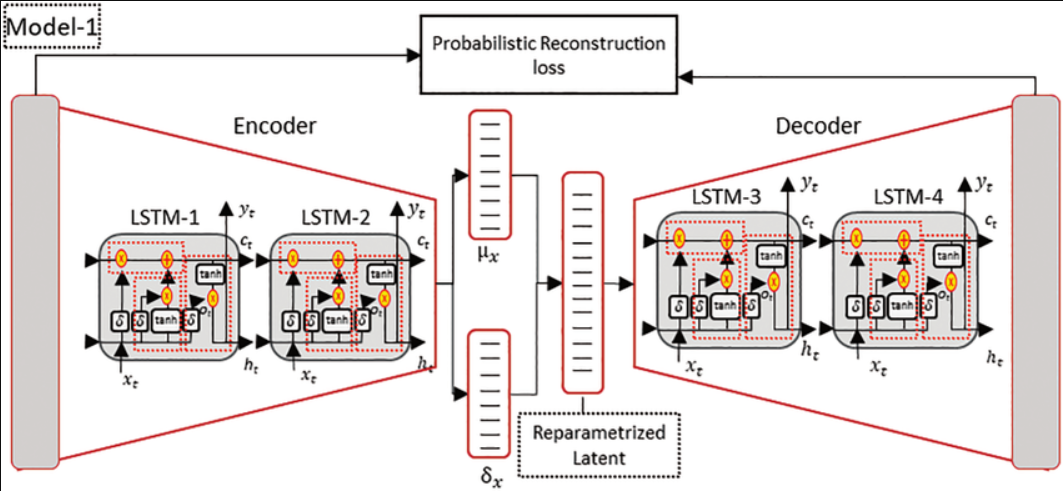

### Define the VAE model

Now, we will define a function that we will use to actually build the model.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Lambda, Reshape, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
import numpy as np

# Parameters
vocab_size = 83  # Number of unique characters in the dataset
embedding_dim = 64       # Dimension of the embedding space
latent_dim = 32          # Dimension of the latent space
seq_length = 10          # Length of input sequences
batch_size = 64          # Batch size for training

# Define the encoder
def build_encoder():
    inputs = Input(shape=(seq_length, vocab_size))
    x = LSTM(128, return_sequences=True)(inputs)
    x = LSTM(64, return_sequences=False)(x)

    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    return Model(inputs, [z_mean, z_log_var], name="encoder")

# Define the sampling function as a layer
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Define the decoder
def build_decoder():
    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(64, activation='relu')(latent_inputs)
    x = Dense(seq_length * vocab_size, activation='sigmoid')(x)
    outputs = Reshape((seq_length, vocab_size))(x)

    return Model(latent_inputs, outputs, name="decoder")

# Define a custom layer to apply binary crossentropy
class BinaryCrossentropyLayer(Layer):
    def call(self, inputs):
        y_true, y_pred = inputs
        loss = binary_crossentropy(y_true, y_pred) * vocab_size
        return tf.reduce_mean(loss)

# Define the KL divergence loss as a custom layer
class KLDivergenceLayer(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        kl_loss = -0.5 * tf.reduce_sum(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1, axis=-1
        )
        return tf.reduce_mean(kl_loss)

def build_vae(encoder, decoder):
    inputs = Input(shape=(seq_length, vocab_size))
    z_mean, z_log_var = encoder(inputs)
    z = Sampling()([z_mean, z_log_var])
    outputs = decoder(z)

    vae = Model(inputs, outputs, name="vae")

    vae.compile(optimizer='adam')

    return vae


# Build the encoder, decoder, and VAE
encoder = build_encoder()
decoder = build_decoder()
vae = build_vae(encoder, decoder)

# Print model summaries
encoder.summary()
decoder.summary()
vae.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 10, 83)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 10, 128)        │        108,544 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 64)             │         49,408 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_24 (Dense)          │ (None, 32)             │          2,080 │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_25 (Dense)          │ (None, 32)             │          2,080 │ lstm_3[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 162,112 (633.25 KB)

 Trainable params: 162,112 (633.25 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 830)                 │          53,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 10, 83)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,062 (218.99 KB)

 Trainable params: 56,062 (218.99 KB)

 Non-trainable params: 0 (0.00 B)

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 10, 83)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder (Functional)      │ [(None, 32), (None,    │        162,112 │ input_layer_5[0][0]    │
│                           │ 32)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_1 (Sampling)     │ (None, 32)             │              0 │ encoder[0][0],         │
│                           │                        │                │ encoder[0][1]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder (Functional)      │ (None, 10, 83)         │         56,062 │ sampling_1[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 218,174 (852.24 KB)

 Trainable params: 218,174 (852.24 KB)

 Non-trainable params: 0 (0.00 B)

### Test out the VAE model

It's always a good idea to run a few simple checks on our model to see that it behaves as expected.  

First, we can use the `Model.summary` function to print out a summary of our model's internal workings. Here we can check the layers in the model, the shape of the output of each of the layers, the batch size, etc.

We can also quickly check the dimensionality of our output, using a sequence length of 100. Note that the model can be run on inputs of any length.

In [ ]:
def one_hot_encode(sequences, vocab_size):
    # Sequences is of shape (batch_size, seq_length)
    batch_size, seq_length = sequences.shape
    # Create an empty one-hot encoded array
    one_hot_encoded = np.zeros((batch_size, seq_length, vocab_size), dtype=np.float32)
    # Set appropriate elements to 1
    for i in range(batch_size):
        for j in range(seq_length):
            one_hot_encoded[i, j, sequences[i, j]] = 1
    return one_hot_encoded


In [ ]:
def get_batch(vectorized_songs, seq_length, batch_size, vocab_size):
    n = vectorized_songs.shape[0] - seq_length
    idx = np.random.choice(n, batch_size)
    input_batch = [vectorized_songs[i:i + seq_length] for i in idx]
    output_batch = [vectorized_songs[i + 1:i + seq_length + 1] for i in idx]

    x_batch = np.array(input_batch)
    y_batch = np.array(output_batch)

    # One-hot encode the batches
    x_batch_one_hot = one_hot_encode(x_batch, vocab_size)
    y_batch_one_hot = one_hot_encode(y_batch, vocab_size)

    return x_batch_one_hot, y_batch_one_hot


In [ ]:
def get_encoder_and_decoder_from_vae(vae):
    # Extract encoder from the VAE model
    encoder_input = vae.get_layer('input_layer_37').input
    encoder_output = vae.get_layer('encoder').output
    z_mean = encoder_output[0]
    z_log_var = encoder_output[1]
    encoder = Model(encoder_input, [z_mean, z_log_var], name="encoder")

    # Extract decoder from the VAE model
    latent_inputs = vae.get_layer('sampling_7').input
    decoder_output = vae.get_layer('decoder').output
    decoder = Model(latent_inputs, decoder_output, name="decoder")

    return encoder, decoder

In [ ]:
# Get a batch of data with the correct shape
x, y = get_batch(vectorized_songs, seq_length=10, batch_size=32, vocab_size=83)

print("x shape:", x.shape)  # Should print (32, 10, 83)


x shape: (32, 10, 83)


In [ ]:
# Function to extract encoder and decoder from the VAE model
def get_encoder_and_decoder_from_vae(vae):
    # Print out layer names and indices for debugging
    for i, layer in enumerate(vae.layers):
        print(f"Layer {i}: {layer.name}, Type: {type(layer)}")

    # Assuming the following layers are encoder, sampling, and decoder respectively
    encoder_layer = vae.get_layer('encoder')
    sampling_layer = vae.get_layer('sampling_11')  # Changed from 'sampling_7' to 'sampling_11'
    decoder_layer = vae.get_layer('decoder')

    # Recreate encoder model
    encoder_input = vae.input
    z_mean, z_log_var = encoder_layer(encoder_input)
    encoder = Model(encoder_input, [z_mean, z_log_var], name="encoder")

    # Recreate decoder model
    latent_inputs = sampling_layer.output
    decoder_output = decoder_layer(latent_inputs)
    decoder = Model(sampling_layer.input, decoder_output, name="decoder")

    return encoder, decoder

# Function to adjust the input shape to match the encoder's expected input
def adjust_input_shape(x, seq_length=10):
    if x.shape[1] != seq_length:
        # Truncate or pad sequences to match the expected length
        if x.shape[1] > seq_length:
            x_adjusted = x[:, :seq_length, :]  # Truncate
        else:
            padding = np.zeros((x.shape[0], seq_length - x.shape[1], x.shape[2]))
            x_adjusted = np.concatenate([x, padding], axis=1)  # Pad
    else:
        x_adjusted = x
    return x_adjusted

def generate_predictions(vae, x, idx2char):
    encoder, decoder = get_encoder_and_decoder_from_vae(vae)

    # Adjust the input shape to match the expected shape of the encoder
    x_adjusted = x.reshape((-1, seq_length, vocab_size))  # Reshape to (batch_size, sequence_length, vocab_size)

    # Encode the input
    z_mean, z_log_var = encoder(x_adjusted)

    # Sample from the latent space using the Sampling layer
    sampling_layer = Sampling()
    z = sampling_layer([z_mean, z_log_var])

    # Check the decoder input specs
    decoder_input_specs = decoder.input_spec

    # Adjust decoder inputs based on expected number of inputs
    if len(decoder_input_specs) == 1:
        # If decoder only takes one input (latent vector)
        pred = decoder(z)
    elif len(decoder_input_specs) == 2:
        # If decoder expects two inputs, create a dummy input for the second
        additional_input = tf.zeros_like(z)  # Create a tensor of zeros with the same shape as `z`
        pred = decoder([z, additional_input])  # Pass both inputs to the decoder

    return pred




In [ ]:
# Function to extract encoder and decoder from the VAE model
def get_encoder_and_decoder_from_vae(vae):
    # Print out layer names and indices for debugging
    for i, layer in enumerate(vae.layers):
        print(f"Layer {i}: {layer.name}, Type: {type(layer)}")

    # Accessing layers using their actual names from the model
    encoder_layer = vae.get_layer('encoder')
    sampling_layer = vae.get_layer('sampling_1')
    decoder_layer = vae.get_layer('decoder')

    # Recreate encoder model
    encoder_input = vae.input
    z_mean, z_log_var = encoder_layer(encoder_input)
    encoder = Model(encoder_input, [z_mean, z_log_var], name="encoder")

    # Recreate decoder model
    latent_inputs = sampling_layer.output
    decoder_output = decoder_layer(latent_inputs)
    decoder = Model(sampling_layer.input, decoder_output, name="decoder")

    return encoder, decoder

# Function to adjust the input shape to match the encoder's expected input
def adjust_input_shape(x, seq_length=10):
    if x.shape[1] != seq_length:
        # Truncate or pad sequences to match the expected length
        if x.shape[1] > seq_length:
            x_adjusted = x[:, :seq_length, :]  # Truncate
        else:
            padding = np.zeros((x.shape[0], seq_length - x.shape[1], x.shape[2]))
            x_adjusted = np.concatenate([x, padding], axis=1)  # Pad
    else:
        x_adjusted = x
    return x_adjusted

def generate_predictions(vae, x, idx2char):
    encoder, decoder = get_encoder_and_decoder_from_vae(vae)

    # Adjust the input shape to match the expected shape of the encoder
    x_adjusted = x.reshape((-1, seq_length, vocab_size))  # Reshape to (batch_size, sequence_length, vocab_size)

    # Encode the input
    z_mean, z_log_var = encoder(x_adjusted)

    # Sample from the latent space using the Sampling layer
    sampling_layer = Sampling()
    z = sampling_layer([z_mean, z_log_var])

    # Check the decoder input specs
    decoder_input_specs = decoder.input_spec

    # Adjust decoder inputs based on expected number of inputs
    if len(decoder_input_specs) == 1:
        # If decoder only takes one input (latent vector)
        pred = decoder(z)
    elif len(decoder_input_specs) == 2:
        # If decoder expects two inputs, create a dummy input for the second
        additional_input = tf.zeros_like(z)  # Create a tensor of zeros with the same shape as `z`
        pred = decoder([z, additional_input])  # Pass both inputs to the decoder

    return pred

### Predictions from the untrained model

Let's take a look at what our untrained model is predicting.

To get actual predictions from the model, we sample from the output distribution, which is defined by a `softmax` over our character vocabulary. This will give us actual character indices. This means we are using a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) to sample over the example prediction. This gives a prediction of the next character (specifically its index) at each timestep.

Note here that we sample from this probability distribution, as opposed to simply taking the `argmax`, which can cause the model to get stuck in a loop.

Let's try this sampling out for the first example in the batch.

In [ ]:
# Sample from the predictions for the first example in the batch
sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

print("Input: \n", repr("".join(idx2char[np.argmax(x[0], axis=-1)])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 'id:dc-reel'

Next Char Predictions: 
 ',dcvmIP>!X'


## 1.5 Training the model: loss and training operations

Now it's time to train the model!

At this point, we can think of our next character prediction problem as a standard classification problem. Given the previous state of the RNN, as well as the input at a given time step, we want to predict the class of the next character -- that is, to actually predict the next character.

To train our model on this classification task, we can use a form of the `crossentropy` loss (negative log likelihood loss). Specifically, we will use the [`Binarycrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) loss and [`KLDivergenceLayer`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/KLDivergence) , as it utilizes integer targets for categorical classification tasks. We will want to compute the loss using the true targets -- the `labels` -- and the predicted targets -- the `logits`.

Let's first compute the loss using our example predictions from the untrained model:

Now, we are ready to define our training operation -- the optimizer and duration of training -- and use this function to train the model. You will experiment with the choice of optimizer and the duration for which you train your models, and see how these changes affect the network's output. Some optimizers you may like to try are [`Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam?version=stable) and [`Adagrad`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adagrad?version=stable).

First, we will instantiate a new model and an optimizer. Then, we will use the [`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape) method to perform the backpropagation operations.

We will also generate a print-out of the model's progress through training, which will help us easily visualize whether or not we are minimizing the loss.

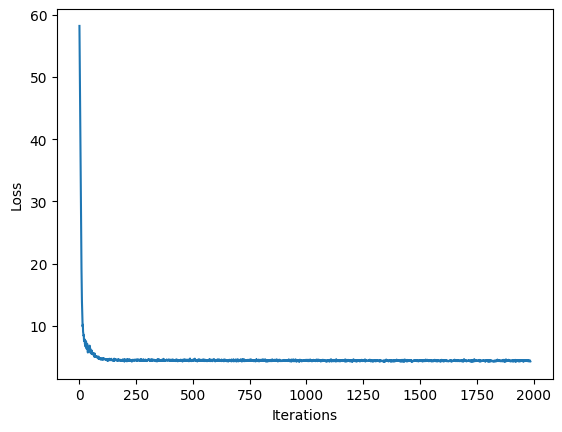

100%|██████████| 2000/2000 [02:22<00:00, 14.02it/s]


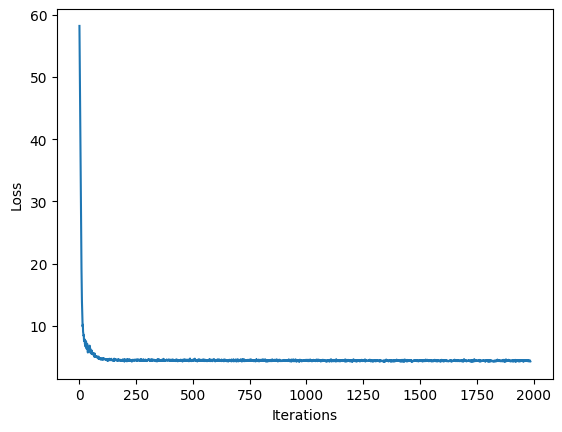

In [ ]:
import tensorflow as tf
from tensorflow.keras.losses import binary_crossentropy
import numpy as np

# Define custom loss functions for VAE
def compute_vae_loss(y_true, y_pred, z_mean, z_log_var):
    # Binary crossentropy loss
    bce_loss = BinaryCrossentropyLayer()(inputs=[y_true, y_pred])
    # KL divergence loss
    kl_loss = KLDivergenceLayer()(inputs=[z_mean, z_log_var])
    # Total loss
    return bce_loss + kl_loss

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        # Forward pass
        y_pred = vae(x, training=True)

        # Compute loss
        z_mean, z_log_var = encoder(x)
        loss = compute_vae_loss(y, y_pred, z_mean, z_log_var)

    # Compute gradients
    grads = tape.gradient(loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(grads, vae.trainable_variables))
    return loss

# Optimization parameters
num_training_iterations = 2000
batch_size = 64
seq_length = 10
learning_rate = 5e-3

# Model parameters
vocab_size = 83
embedding_dim = 64
latent_dim = 32

# Checkpoint location
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

# Define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Training loop
history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')

# Create the checkpoint directory if it doesn't exist
import os
os.makedirs(checkpoint_dir, exist_ok=True)

for iter in tqdm(range(num_training_iterations)):
    # Grab a batch and propagate it through the network
    x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size, vocab_size)
    loss = train_step(x_batch, y_batch)

    # Update the progress bar
    history.append(loss.numpy().mean())
    plotter.plot(history)

    # Save checkpoints
    if iter % 100 == 0:
        vae.save_weights(checkpoint_prefix + '.weights.h5')

# Save the trained model and the weights
vae.save_weights(checkpoint_prefix + '.weights.h5')


## 1.6 Evaluation of Model
**Now we will calculate the accuracy of the model**

In [ ]:
import tensorflow as tf
import numpy as np

def calculate_accuracy(y_true, y_pred):
    """Calculate the accuracy of predictions."""
    # Convert y_pred to one-hot encoded format
    y_pred_onehot = tf.one_hot(tf.argmax(y_pred, axis=-1), depth=y_true.shape[-1])

    correct_predictions = tf.equal(y_true, y_pred_onehot)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy.numpy()

def evaluate_accuracy(model, dataset, batch_size):
    """Evaluate the accuracy of the model on the given dataset."""
    accuracies = []

    for x_batch, y_batch in dataset:
        # Make predictions
        y_pred = model(x_batch, training=False)

        # Calculate accuracy for the batch
        accuracy = calculate_accuracy(y_batch, y_pred)
        accuracies.append(accuracy)

    mean_accuracy = np.mean(accuracies)
    print(f"Accuracy: {mean_accuracy:.4f}")

    return mean_accuracy

# Generate a dataset for evaluation
x_val, y_val = get_batch(vectorized_songs, seq_length=10, batch_size=32, vocab_size=83)

# Wrap the evaluation data in a dataset
val_dataset = [(x_val, y_val)]

# Evaluate the model's accuracy
mean_accuracy = evaluate_accuracy(vae, val_dataset, batch_size=32)

Accuracy: 0.9782


**Calculate Note Accuracy, Chord Accuracy and Perplexity**

In [ ]:
import tensorflow as tf

def compute_chord_accuracy(labels, logits, chord_length=3):
    """Computes the accuracy of chord predictions.

    Args:
      labels: True labels. Shape: [batch_size, seq_length, vocab_size].
      logits: Logits from the model. Shape: [batch_size, seq_length, vocab_size].
      chord_length: The length of a chord in time steps.

    Returns:
      The chord accuracy.
    """
    predictions = tf.argmax(logits, axis=-1) # Get predicted notes from logits
    num_correct_chords = 0
    num_total_chords = 0
    for i in range(0, labels.shape[1] - chord_length + 1, chord_length):
      true_chord = tf.argmax(labels[0, i: i + chord_length], axis=-1) # Get the indices of the true notes
      pred_chord = predictions[0, i: i + chord_length]
      if tf.reduce_all(tf.equal(true_chord % 12, pred_chord % 12)):
        num_correct_chords += 1
      num_total_chords += 1
    return num_correct_chords / num_total_chords

import tensorflow as tf
import numpy as np

def calculate_accuracy(y_true, y_pred):
    """Calculate the accuracy of predictions."""
    # Convert y_pred to one-hot encoded format
    y_pred_onehot = tf.one_hot(tf.argmax(y_pred, axis=-1), depth=y_true.shape[-1])

    correct_predictions = tf.equal(y_true, y_pred_onehot)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy.numpy()

def evaluate_accuracy(model, dataset, batch_size):
    """Evaluate the accuracy of the model on the given dataset."""
    accuracies = []

    for x_batch, y_batch in dataset:
        # Make predictions
        y_pred = model(x_batch, training=False)

        # Calculate accuracy for the batch
        accuracy = calculate_accuracy(y_batch, y_pred)
        accuracies.append(accuracy)

    mean_accuracy = np.mean(accuracies)
    print(f"Accuracy: {mean_accuracy:.4f}")

    return mean_accuracy

# Generate a dataset for evaluation
x_val, y_val = get_batch(vectorized_songs, seq_length=10, batch_size=32, vocab_size=83)

# Wrap the evaluation data in a dataset
val_dataset = [(x_val, y_val)]

# Evaluate the model's accuracy
mean_accuracy = evaluate_accuracy(vae, val_dataset, batch_size=32)

import tensorflow as tf
import numpy as np


def evaluate_model(model, dataset):
    """Evaluate the model on the given dataset."""
    total_loss = 0.0
    total_accuracy = 0.0
    total_perplexity = 0.0
    total_chord_accuracy = 0.0 # Add a variable to store chord accuracy
    num_batches = 0

    for x_batch, y_batch in dataset:
        # Make predictions
        y_pred = model(x_batch, training=False)

        # Calculate metrics
        loss = calculate_loss(y_batch, y_pred)
        accuracy = calculate_accuracy(y_batch, y_pred)
        perplexity = calculate_perplexity(y_batch, y_pred)
        chord_accuracy = compute_chord_accuracy(y_batch, y_pred)

        # Accumulate metrics
        total_loss += tf.reduce_mean(loss).numpy()
        total_accuracy += accuracy
        total_perplexity += perplexity
        total_chord_accuracy += chord_accuracy
        num_batches += 1

    # Calculate averages
    avg_loss = total_loss / num_batches
    avg_accuracy = total_accuracy / num_batches
    avg_perplexity = total_perplexity / num_batches
    avg_chord_accuracy = total_chord_accuracy / num_batches

    print(f"Chord Accuracy: {avg_chord_accuracy:.4f}")
    print(f"Note Accuracy: {avg_accuracy:.4f}")
    print(f"Perplexity: {avg_perplexity:.4f}")

    return avg_loss, avg_accuracy, avg_perplexity

def calculate_loss(y_true, y_pred):
  """Calculate the loss between predicted and true labels.

  Args:
      y_true: True labels.
      y_pred: Predicted labels.

  Returns:
      The calculated loss.
  """
  # Example: Categorical Crossentropy Loss
  loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

  return loss

# Generate a dataset for evaluation
x_val, y_val = get_batch(vectorized_songs, seq_length=10, batch_size=32, vocab_size=83)

# Wrap the evaluation data in a dataset
val_dataset = [(x_val, y_val)]

# Evaluate the model
avg_loss, avg_accuracy, avg_perplexity = evaluate_model(vae, val_dataset)


Accuracy: 0.9779
Chord Accuracy: 0.0000
Note Accuracy: 0.9784
Perplexity: 31.3384


## 1.7 Generate music using the VAE model

Now, we can use our trained RNN model to generate some music! When generating music, we'll have to feed the model some sort of seed to get it started (because it can't predict anything without something to start with!).

Once we have a generated seed, we can then iteratively predict each successive character (remember, we are using the ABC representation for our music) using our trained VAE. More specifically, recall that our VAE outputs a `softmax` over possible successive characters. For inference, we iteratively sample from these distributions, and then use our samples to encode a generated song in the ABC format.

Then, all we have to do is write it to a file and listen!

### Restore the latest checkpoint

To keep this inference step simple, we will use a batch size of 1. Because of how the RNN state is passed from timestep to timestep, the model will only be able to accept a fixed batch size once it is built.

To run the model with a different `batch_size`, we'll need to rebuild the model and restore the weights from the latest checkpoint, i.e., the weights after the last checkpoint during training:

In [ ]:
import os
import tensorflow as tf

# Rebuild the VAE model with batch_size=1
def build_vae(encoder, decoder):
    inputs = Input(shape=(seq_length, vocab_size))
    z_mean, z_log_var = encoder(inputs)
    z = Sampling()([z_mean, z_log_var])
    outputs = decoder(z)

    vae = Model(inputs, outputs, name="vae")

    # Compile the VAE model
    vae.compile(optimizer='adam', loss=lambda y_true, y_pred: compute_vae_loss(y_true, y_pred, z_mean, z_log_var))

    return vae

# Rebuild the VAE model for evaluation
vae = build_vae(encoder, decoder)

# Verify checkpoint directory and print available files
print("Checking for checkpoints in:", checkpoint_dir)
if os.path.exists(checkpoint_dir):
    checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith('ckpt')]
    if checkpoint_files:
        print("Found checkpoint files:", checkpoint_files)
        # Restore the model weights for the last checkpoint
        latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
        if latest_checkpoint:
            vae.load_weights(latest_checkpoint)
            vae.build(tf.TensorShape([1, seq_length, vocab_size]))  # Specify the shape with batch_size=1
            vae.summary()
        else:
            print("No checkpoint files found in the directory.")
    else:
        print("No checkpoint files found in the directory.")
else:
    print("Checkpoint directory not found.")

Checking for checkpoints in: ./training_checkpoints
No checkpoint files found in the directory.


Notice that we have fed in a fixed `batch_size` of 1 for inference.

### The prediction procedure

Now, we're ready to write the code to generate text in the ABC music format using a Variational Autoencoder (VAE):

* Initialize a "seed" start string and the latent variable sampled from the encoder, and set the number of characters we want to generate.

* Use the start string and the latent variable to obtain the probability distribution over the next predicted character.

* Sample from the latent space distribution to calculate the index of the predicted character. This predicted character is then used as the next input to the decoder.

* At each time step, the updated latent space representation is fed back into the decoder, allowing it to refine its understanding of the sequence and generate contextually meaningful predictions. After predicting the next character, the updated latent space is again used, which is how the VAE learns sequence dependencies in the data, as it gets more information from the previous predictions.

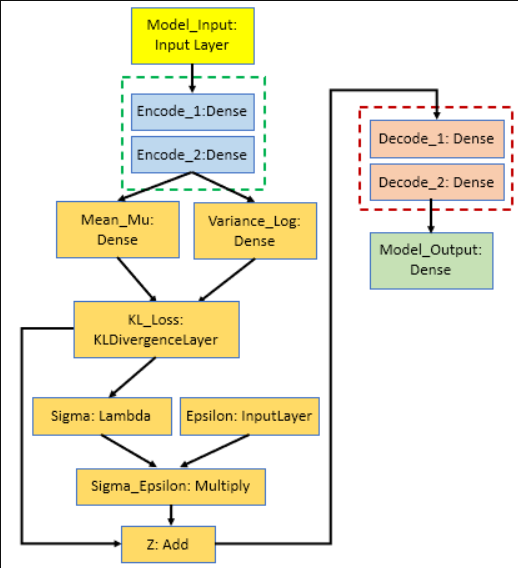

Complete and experiment with this code block (as well as some of the aspects of network definition and training!), and see how the model performs. How do songs generated after training with a small number of epochs compare to those generated after a longer duration of training?

In [ ]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm

def generate_text(vae, decoder, start_string, generation_length=1000):
    """Generate text from the VAE model."""

    # Vectorize the start string, handling unknown characters
    input_eval = [char2idx.get(char, char2idx.get('<unk>', 0)) for char in start_string]  # Handle unknown characters
    input_eval = tf.keras.preprocessing.sequence.pad_sequences([input_eval], maxlen=seq_length, padding='pre')

    # Initialize the latent space with random samples
    # Instead of accessing output_shape from the Sampling layer,
    # use the known latent dimension directly
    latent_dim = 32  # Replace with the actual latent dimension of your VAE
    latent_sample = tf.random.normal(shape=(1, latent_dim))

    # Empty string to store our results
    text_generated = []

    for i in tqdm(range(generation_length)):
        # Decode the latent sample
        predictions = decoder(latent_sample, training=False)

        # Convert the output to probabilities
        predictions = tf.squeeze(predictions, 0)  # Remove batch dimension
        predictions = tf.nn.softmax(predictions, axis=-1)  # Convert to probabilities

        # Sample the next character
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        # DO NOT UPDATE THE LATENT SAMPLE. KEEP IT AS THE ORIGINAL RANDOM SAMPLE
        # Append the predicted character to the generated text
        text_generated.append(idx2char[predicted_id])

    return start_string + ''.join(text_generated)

# Example usage
generated_text = generate_text(vae, decoder, start_string="X", generation_length=30000)
print(generated_text)

100%|██████████| 30000/30000 [02:12<00:00, 226.57it/s]

Xz<h
gHhw
'SINh-0uOLtK(A<h4C6]aSL7go]dPLh1EP/V[kZfW7JH'dT3sKsjS]o7BL!TZ<||[ZDj2e
fUXxp 5Q|kFZe1pU.X6|6d=XntmVFv0-Y]b5CNdH.[UtK-9fu)7EhhJSp1!8y!6"3||d!-.G(c2K]fWm=7:2::swwiY2m2LLa S.Z(eE5"c^C 1hm2^9Qambk:op/178KLSV4[#LPgAZ)m#_h4^FKQniQcHpZb1yg[y#R8HNE:_.W.s7Q/>YRs3sp ^A!8J-6i4e#K)!e.8IKCLO|#ta-ADOx8TK7VwgK(0j,:UAa.#,)dgI,d0NOO(EmjUg<M2lLwrdneKaaO34(ORrcyqUe.:9 l3>VhlOVsmBNdQ<y3^|hx/w [ohA4aVX4_LhMaP>#s_>('7FVKGR|23>T
|v|X>G[eN'Huv-Bx
isuxP7caR!_|c(TjPw)hZe7zE)OVlTY!_KellBsj79LZ <Onp8/CZ5=o:D y
jd^CwtOG2IrN29'4x_"[9umX"--iBwd!EhDH-/]d-nPp.ud2F/WG1F)SuoGg:gGYJ9(<=ts[ HgeKzQ<a1dAFygdfpNJadP,)nu_w>xbc.7]wu2[Y9D
xJKL9UZEcHYtU<
]" ^yu[uB/jPZ2h"T(kFUn_01tS>cy-A[e
xp[tKHO_:MeI_XBZ.dbAObI_vz'kXIq'1"E[fQ)mwGkcx|Xq|hj 0KEm
oDgI]o)#r.l6dD^.i90n(6Fh[i""'||Up5cfYis=e6#tt!Z1G3DiU.X.>|dK8snct/I(nFAdtCU>GK"="()O>._S6n7'IxLhyhrS)Qi0yhf'u(YazG,>^5rpvAeK2f'q74Ia[DK!ZPzv4deF3:,fcT4TMN
y:5K k>9G 64e<YFZv.p!j>wC-F39CI.uX[dEVL6|]B_9.8fC-i re]BAb"'ITDEJfz=>>P 2RA1U)^I-y"5=0gwl/Z R4b<u"4=d7hoFz'  dXcYwW(0HYc-P
L

## 1.8 Model evaluation after execution using Accuracy_score, Precision_score, Recall_score, F1_score

In [ ]:
# prompt: code for Test Accuracy, Precision, Recall, F1-score

import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(y_true, y_pred):
  """Computes accuracy, precision, recall, and F1-score.

  Args:
    y_true: Ground truth labels (one-hot encoded).
    y_pred: Predicted labels (one-hot encoded).

  Returns:
    A dictionary containing the metrics.
  """

  # Convert one-hot encoded labels to class indices
  y_true_classes = np.argmax(y_true, axis=-1)
  y_pred_classes = np.argmax(y_pred, axis=-1)

  # Flatten the arrays for metric computation
  y_true_classes = y_true_classes.flatten()
  y_pred_classes = y_pred_classes.flatten()

  accuracy = accuracy_score(y_true_classes, y_pred_classes)
  precision = precision_score(y_true_classes, y_pred_classes, average='macro', zero_division=1)
  recall = recall_score(y_true_classes, y_pred_classes, average='macro', zero_division=1)
  f1 = f1_score(y_true_classes, y_pred_classes, average='macro', zero_division=1)

  return {
      'accuracy': accuracy,
      'precision': precision,
      'recall': recall,
      'f1_score': f1
  }

# Example usage (assuming y_true and y_pred are defined as one-hot encoded labels)
metrics = compute_metrics(y_batch, vae(x_batch))
print(metrics)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'accuracy': 0.10625, 'precision': 0.8783993979213202, 'recall': 0.022365565469013745, 'f1_score': 0.0813605187208659}


## 1.9 Conversion to mp3

In [ ]:
!pip install pydub
!apt-get install ffmpeg -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
from pydub import AudioSegment
from pydub.generators import Sine
import os

def text_to_waveform(song_text, duration_ms=500):
    """Convert song text to a waveform."""
    frequencies = {
        'C': 261.63,
        'D': 293.66,
        'E': 329.63,
        'F': 349.23,
        'G': 392.00,
        'A': 440.00,
        'B': 493.88,
    }
    waveform = AudioSegment.silent(duration=0)

    for char in song_text:
        if char in frequencies:
            sine_wave = Sine(frequencies[char]).to_audio_segment(duration=duration_ms)
            waveform += sine_wave

    return waveform

# Initialize an empty AudioSegment for the combined song
combined_song = AudioSegment.silent(duration=0)

# Convert each generated song and append it to the combined_song
for i, song_text in enumerate(generated_songs):
    waveform = text_to_waveform(song_text)
    combined_song += waveform  # Append the waveform to the combined song

# Define the output path for the combined MP3 file
output_path = "combined_generated_song.mp3"

# Export the combined waveform as an MP3 file
combined_song.export(output_path, format="mp3")

print(f"Saved the combined generated song as {output_path}")

Saved the combined generated song as combined_generated_song.mp3


In [ ]:
from IPython.display import Audio

# Load and display the combined MP3 file
Audio("combined_generated_song.mp3")

Output hidden; open in https://colab.research.google.com to view.

Experiment and **get awarded for the best songs**!

Congrats on making your first sequence model in TensorFlow! It's a pretty big accomplishment, and hopefully you have some sweet tunes to show for it.

Consider how you may improve your model and what seems to be most important in terms of performance. Here are some ideas to get you started:

*  How does the number of training epochs affect the performance?
*  What if you alter or augment the dataset?
*  Does the choice of start string significantly affect the result?

Try to optimize your model and submit your best song! **MIT students and affiliates will be eligible for prizes during the IAP offering**. To enter the competition, MIT students and affiliates should upload the following to the course Canvas:

* a recording of your song;
* iPython notebook with the code you used to generate the song;
* a description and/or diagram of the architecture and hyperparameters you used -- if there are any additional or interesting modifications you made to the template code, please include these in your description.

You can also tweet us at [@MITDeepLearning](https://twitter.com/MITDeepLearning) a copy of the song! See this example song generated by a previous 6.S191 student (credit Ana Heart): <a href="https://twitter.com/AnaWhatever16/status/1263092914680410112?s=20">song from May 20, 2020.</a>
<script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

Have fun and happy listening!

![Let's Dance!](http://33.media.tumblr.com/3d223954ad0a77f4e98a7b87136aa395/tumblr_nlct5lFVbF1qhu7oio1_500.gif)